Things to test:
- Smaller window (2-3 coulomb peak)
  Z[50:150, 20:120]. If it has a transition, check that it still finds a transition
  -> This works pretty good but determining the gradient becomes more uncertain.
- Lower resolution (e.g.60x60 points, decimation)
  Z[20:120:5, 20:120:5] Adds a 5x decimation (only use every 5th)
- Add noise
  Z + alpha *np.random.uniform(Z.size) adds noise with magnitude alpha
  
Feel free to combine multiple tests

FILTERING DISCUSSION:
Filtering Z prior seems to lose information but also could really help mitigate noise.
Filtering theta seems to help increase contrast in transiion gradient matrices. 
Filtering transition gradient matrices doesn't seem to be good for anything at the moment... but we'll see, i won't rule it out.

Deleting transitions needs to fully black out transitions for proper operation. Additionally, crossing transitions need to be accounted for.
Transgrad needs to be calculated more carefully. 


Plan:
- do the todo and add more explainations
- Make a function to test sweeps and display it nicely
  Ideal function:
  - Input: X, Y, Z, data
  - Output: slope of transition(s) while varying gate (Z)

- test this on new test data

- If time, use capacitance matrix to find location of the donor.


May find useful:
https://matplotlib.org/examples/color/colormaps_reference.html

In [49]:
import qcodes as qc
import numpy as np
from scipy import signal
conv2 = signal.convolve2d
peaks = signal.find_peaks
from matplotlib import pyplot as plt

import detect_peaks
from importlib import reload
reload(detect_peaks )
from detect_peaks import *

In [3]:
#qc.data.data_set.DataSet.default_io.base_location = r'/Users/Dennis/Documents/Uni/ThesisB/Jupyter'
data = qc.load_data('CSD/2018-03-26/#004_4D_DC_TGAC_DBL_DBR_14-51-19')
data

DataSet:
   location = 'CSD/2018-03-26/#004_4D_DC_TGAC_DBL_DBR_14-51-19'
   <Type>   | <array_id>          | <array.name> | <array.shape>
   Setpoint | DC_control_DFR_set  | DFR          | (3,)
   Setpoint | DC_control_DFL_set  | DFL          | (3, 3)
   Setpoint | DBL_DBR_set         | DBL_DBR      | (3, 3, 301)
   Setpoint | DC_control_TGAC_set | TGAC         | (3, 3, 301, 251)
   Measured | DC_voltage          | DC_voltage   | (3, 3, 301, 251)

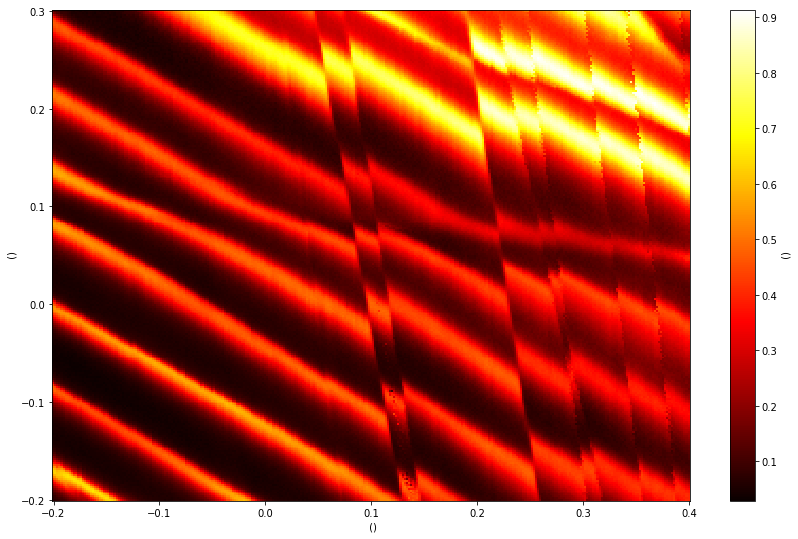

In [31]:
# importing data
x = data.DBL_DBR_set[1,1,:]
y = data.DC_control_TGAC_set[1,1,1,:]
Z = data.DC_voltage[1,2,:,:] #change these values for different datasets
#00 none 
#01 one clear
#02 three clear
#10 four clear
#11 five messy
#12 seven ok clarity. See this one for two transitions crossing clearly
#20 five messy at end
#21 six messy
#22 seven clearish
Z = np.swapaxes(Z,0,1)
    
#reduced sample size
#still works fine at locating, but determining gradient becomes less accurate
#x = x[145:250]
#y = y[125:251]
#Z = Z[125:251,145:250]

# decimation
#works fine locating up to 3x decimation. gradient becomes less accurate
#dec = 3;
#x = x[0:300:dec] 
#y = y[0:250:dec]
#Z = Z[0:250:dec,0:300:dec]

#Add noise
#filtering does clear this up BUT this outlines an issue with calculating transgrad.
#transgrad needs to take into account the relative maximums. otherwise noise greatly interferes. Improving transgrad
#calculations will make the system much more reliable
#alpha = 0.05
#Z = Z + alpha*np.random.uniform(-1,1,size=Z.shape)

plot = qc.MatPlot(Z,x=x,y=y,  figsize=(12,8))
#0.408
#0.203 #0.367 on 20 due to scanning error
#seems to work better in the centre of the image
#nonetheless, this works fully on all sample data. I hope it is not very overfitted

In [51]:
#%%timeit
#use this to find transitions
reload(detect_peaks )
from detect_peaks import*

# transitions = find_transitions(Z,x,y, true_units=True, charge_transfer=False, plot='Off')
transitions = find_transitions(Z,x,y)
transitions

[{'gradient': -7.2058823529411766,
  'gradient_error': 2.9437229437229426,
  'intensity': 0.83809523809523812,
  'location': 172},
 {'gradient': -6.125,
  'gradient_error': 2.5015634771732298,
  'intensity': 0.8326530612244899,
  'location': 164},
 {'gradient': -7.2058823529411766,
  'gradient_error': 2.9437229437229426,
  'intensity': 0.79229024943310655,
  'location': 229},
 {'gradient': -9.0740740740740744,
  'gradient_error': 3.7087912087912125,
  'intensity': 0.79047619047619055,
  'location': 251},
 {'gradient': -10.652173913043478,
  'gradient_error': 4.356060606060602,
  'intensity': 0.77596371882086157,
  'location': 294},
 {'gradient': -8.75,
  'gradient_error': 3.5759897828863298,
  'intensity': 0.75646258503401353,
  'location': 278},
 {'gradient': -4.8039215686274508,
  'gradient_error': 1.9615384615384646,
  'intensity': 0.55419501133786853,
  'location': 260}]

Timing done with 0,2 mid-september:
- 8.16s full range
- 4.09s reduced transgrad range
- 3.38s reduced delete_trans
- 2.94s reduced calc_transgrad
- -> 2.7x speedup

Timing done with 2,2 1-10-18
- 6.14 s ± 634 ms   before adding theta_deviation
- 3.52 s ± 46.8 ms  after adding theta_deviation
- -> 1.7x speedup


- -> 4.6x speedup overall

In [ ]:
#use this to demonstrate how the program works
theta = calculate_theta_matrix(Z, filter=True)
theta_mode = find_matrix_mode(theta)
theta_dev = calculate_theta_deviation(theta,theta_mode)
transgrad = calculate_transition_gradient(theta_dev)
plot_transition_gradient(transgrad,theta_dev)

In [ ]:
#run this multiple times to step through the process
gradient,location = max_index(transgrad)
theta_dev = delete_transition(theta_dev, location, gradient)
transgrad = calculate_transition_gradient(theta_dev)
plot_transition_gradient(transgrad,theta_dev)

In [ ]:
## Use this to generate test sweep data
Z = np.swapaxes(data.DC_voltage[1,0,:,:],0,1)
x1 = 120
x2 = 250
n = 10
Z_s = np.zeros((n,125,x2-x1))
x_s = x[x1:x2]
y_s = y[125:250]
for i in range(n):
    #np.append((Z_sweep,Z[125:250,x1:x2]),axis=0)
    Z_s[i,:,:] = Z[125:250,x1:x2]
    qc.MatPlot(Z_s[i,:,:], figsize=(5,5))
    x1 = x1+3
    x2 = x2+3

#00 none 
#01 one clear
#02 three clear
#10 four clear
#11 five messy
#12 seven ok clarity. See this one for two transitions crossing clearly
#20 five messy at end
#21 six messy
#22 seven clearish

# n = 3
# Z_s = np.zeros((n,251,301))
# x_s = x
# y_s = y
# for i in range(n):
#     #take a look at 2,i, looks pretty cool. i,2 has some cool ones too.
#     Z_s[i,:,:] = np.swapaxes(data.DC_voltage[2,i,:,:],0,1)
#     qc.MatPlot(Z_s[i,:,:], figsize=(8,5))
    

In [ ]:
#get a better name for M
n_s = Z_s.shape[0]
n_x     = Z_s.shape[2]
#first axis is sweep
#second axis is start position
#value stored is gradient
#this needs to be expanded for multiple gradients at same location

M = np.zeros((n_s,n_x))
for i in range(n_s):
    transitions = find_transitions(Z_s[i,:,:],x_s,y_s)
    for k in range(len(transitions)):
        M[i,transitions[k]['location']] = transitions[k]['gradient']

In [ ]:
qc.MatPlot(M, figsize=(8,5))